## Modelos para detecção de fraudes com Machine Learning

### Contextualização

* Objetivo

Criar um sistema que ao entrar com os dados, retorna se a transação é fraude.

* Input

Conjunto de dados de 284.807 amostras e 31 colunas.

* Output

Modelo treinado com Machine Learning, salvo em formato pickle e resultados salvos em um banco de dados ou planilha.

* Referência

https://carlosbonfim.com/pages/Modelo_Preditivo_para_detec%C3%A7%C3%A3o_fraudes.html

* Base de Dados

Kagle: https://www.kaggle.com/mlg-ulb/creditcardfraud

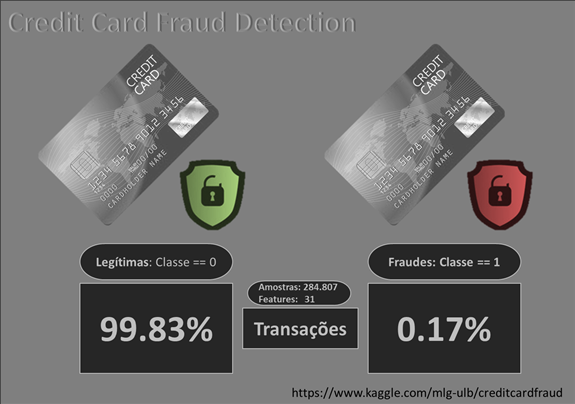

## Importando Bibliotecas

In [19]:
# manipulação e visualização
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# machine learning
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit

# métricas de avaliação
from sklearn.metrics import precision_recall_curve, average_precision_score, confusion_matrix, auc, roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report

# Reamostragem dos dados
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import NearMiss, RandomUnderSampler

# outras
import time
import pickle
import warnings
from scipy import interp
from pprint import pprint
from scipy.stats import norm
from collections import Counter
from imblearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline

# melhorar a visualização
%matplotlib inline
mpl.style.use('ggplot')
plt.style.use('fivethirtyeight')
sns.set(context='notebook', palette='dark', color_codes=True)

# mesagens de warning
warnings.filterwarnings("ignore")

In [26]:
# importando o arquivo
df =pd.read_csv('creditcard.csv')
# visualizando as primeiras linhas
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


## Análise Exploratória dos Dados

In [27]:
# visualizando suas dimensões
df.shape

(43664, 31)

In [28]:
# visualizando a quantidade em cada linha e seu formato
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43664 entries, 0 to 43663
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    43664 non-null  int64  
 1   V1      43664 non-null  float64
 2   V2      43664 non-null  float64
 3   V3      43664 non-null  float64
 4   V4      43664 non-null  float64
 5   V5      43664 non-null  float64
 6   V6      43664 non-null  float64
 7   V7      43664 non-null  float64
 8   V8      43664 non-null  float64
 9   V9      43664 non-null  float64
 10  V10     43664 non-null  float64
 11  V11     43664 non-null  float64
 12  V12     43664 non-null  float64
 13  V13     43664 non-null  float64
 14  V14     43664 non-null  float64
 15  V15     43664 non-null  float64
 16  V16     43664 non-null  float64
 17  V17     43664 non-null  float64
 18  V18     43664 non-null  float64
 19  V19     43664 non-null  float64
 20  V20     43664 non-null  float64
 21  V21     43664 non-null  float64
 22

In [ ]:
# visualizando as estatísticas
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Transações sem fraudes: 99.69%
Transações com fraudes: 0.31%



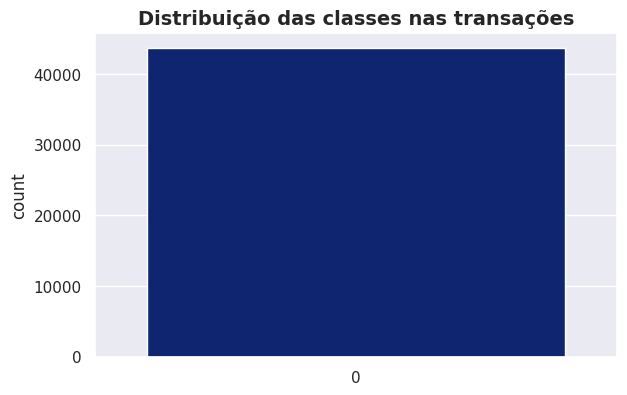

In [29]:
# imprimindo a quantidade de cada classe
print(f'Transações sem fraudes: {round(df.Class.value_counts(normalize=True)[0]*100, 2)}%')
print(f'Transações com fraudes: {round(df.Class.value_counts(normalize=True)[1]*100, 2)}%\n')

# definindo a área de plotagem
plt.figure(figsize=(6,4))

# plotando o gráfico
sns.countplot(df.Class)

# definindo título
plt.title('Distribuição das classes nas transações', fontweight='bold', fontsize=14)

# exibindo o gráfico
plt.show()

# Machine Learning

In [30]:
# Separando os dados para treino e teste
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
# visualizando as proporções da variável alvo
df_train.Class.value_counts(normalize=True)

0    0.998271
1    0.001729
Name: Class, dtype: float64

In [ ]:
# Definindo o Baseline

# dividindo X e y
X = df_train.drop('Class', axis=1)
y = df_train.Class

# separando os dados mantendo a porcentagem de amostras em cada classe
StratifKfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# looping para separar os dados em treino e validação
for train_index, val_index in StratifKfold.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

In [ ]:
# checando as proporções da classe 1 na divisão
print(f'Dimensões: {X_train.shape, X_val.shape, y_train.shape, y_val.shape}\n')
print(f"Proporção do df_train para classe=1: {round(len(df_train[df_train.Class==1]) / df_train.shape[0], 4)}\n")
print(f"Proporção de X_train para classe=1:  {round(len(y_train[y_train==1]) / X_train.shape[0], 4)}")
print(f"Proporção de X_val para classe=1:    {round(len(y_val[y_val==1]) / X_val.shape[0], 4)}")

Dimensões: ((182276, 30), (45569, 30), (182276,), (45569,))

Proporção do df_train para classe=1: 0.0017

Proporção de X_train para classe=1:  0.0017
Proporção de X_val para classe=1:    0.0017


In [ ]:
# instanciando o modelo
logReg = LogisticRegression()

# treinando o modelo
logReg.fit(X_train, y_train)

# prevendo nos dados de treino
y_pred_base_train = logReg.predict(X_train)

# prevendo nos dados de validação
y_pred_base_val = logReg.predict(X_val)

print('Nos dados de TREINO:')

print('---' * 20)
print('Modelo:    Regressão Logística (baseline)\n')
print(f"accuracy:  {accuracy_score(y_train, y_pred_base_train)}")
print(f"precision: {precision_score(y_train, y_pred_base_train)}")
print(f"recall:    {recall_score(y_train, y_pred_base_train)}")
print(f"f1:        {f1_score(y_train, y_pred_base_train)}")
print()
print('---' * 20)
print('---' * 20)
print()
print('Nos dados de VALIDAÇÃO:')
print('---' * 20)
print('Modelo:    Regressão Logística (baseline)\n')
print(f"accuracy:  {accuracy_score(y_val, y_pred_base_val)}")
print(f"precision: {precision_score(y_val, y_pred_base_val)}")
print(f"recall:    {recall_score(y_val, y_pred_base_val)}")
print(f"f1:        {f1_score(y_val, y_pred_base_val)}")
print('---' * 20)

Nos dados de TREINO:
------------------------------------------------------------
Modelo:    Regressão Logística (baseline)

accuracy:  0.999017972744629
precision: 0.7344827586206897
recall:    0.6761904761904762
f1:        0.7041322314049587

------------------------------------------------------------
------------------------------------------------------------

Nos dados de VALIDAÇÃO:
------------------------------------------------------------
Modelo:    Regressão Logística (baseline)

accuracy:  0.9987052601549299
precision: 0.6428571428571429
recall:    0.569620253164557
f1:        0.6040268456375839
------------------------------------------------------------


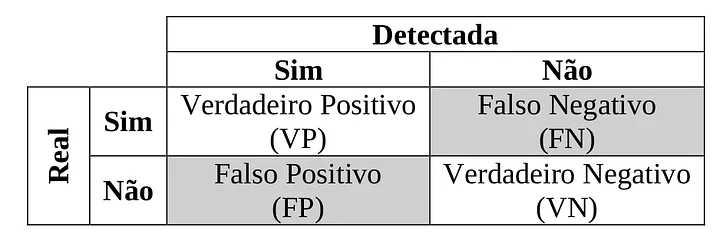

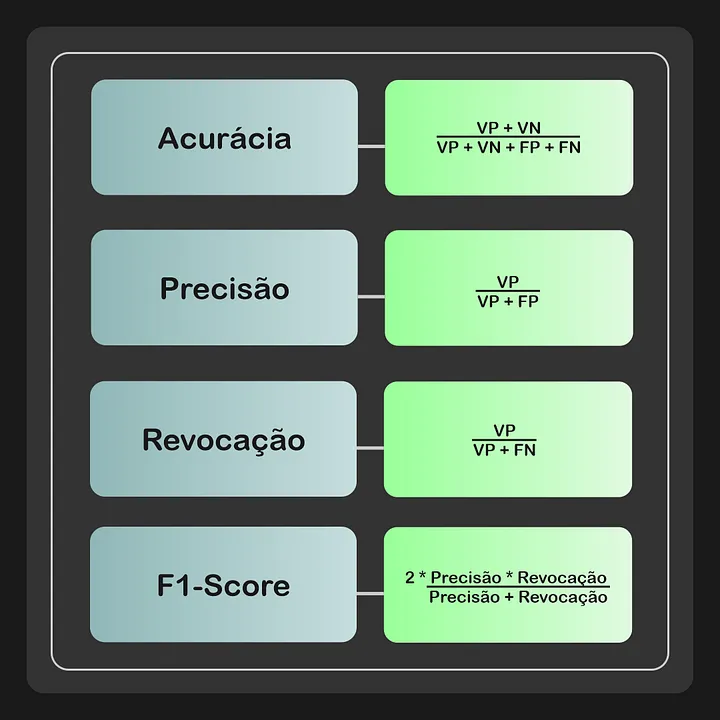

## Reamostragem, teste e validação

* **Distribuição (Random UnderSampling)**: As técnicas de subamostragem ou Undersampling aleatória removem exemplos do conjunto de dados de treinamento que pertencem à classe majoritária para equilibrar melhor a distribuição da classe, como reduzir a distorção de 1:100 para 1:10, 1:2 ou mesmo uma classe 1:1 distribuição.

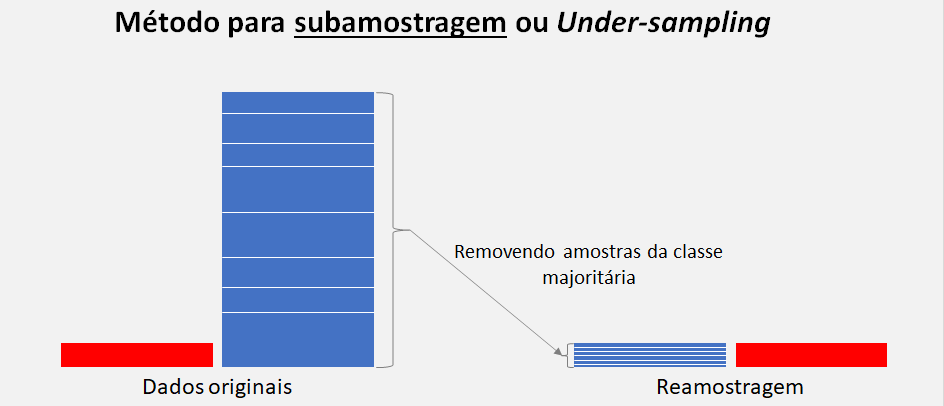

* **Distribuição (Random Over-Sampling)**: A sobreamostragem aleatória envolve a seleção aleatória de exemplos da classe minoritária, com substituição e sua adição ao conjunto de dados de treinamento.

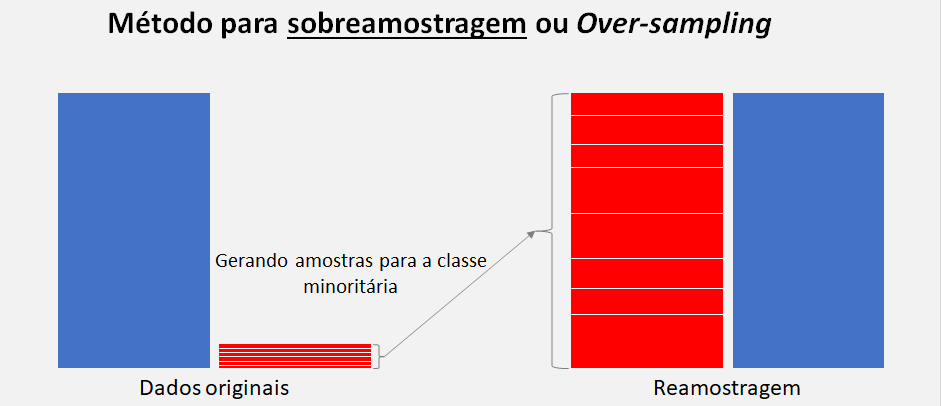


* **SMOTE (Over-Sampling)**: Synthetic Minority Oversampling Technique ou Técnica de sobreamostragem de minoria sintética é a abordagem mais simples e envolve a duplicação de exemplos na classe minoritária, embora esses exemplos não adicionem nenhuma informação nova ao modelo, esses novos exemplos podem ser sintetizados a partir dos exemplos existentes.

* **Híbrido: Oversampling e Undersampling**: É a combinação das duas técnicas descritas anteriormente e como essas duas transformações são realizadas em classes separadas, a ordem em que são aplicadas ao conjunto de dados de treinamento não importa, então podemos definir um pipeline, por exemplo, que primeiro a sobreamostra a classe minoritária para 10% da classe majoritária e em seguida a subamostra a classe majoritária para 50% a mais do que a classe minoritária e, por fim ajusta-se a um modelo de Machine Learning.

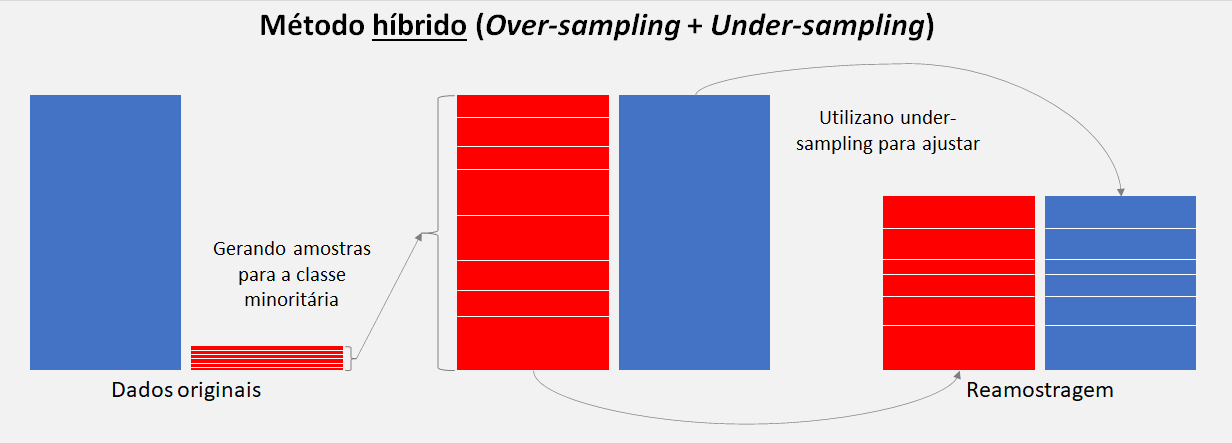




In [ ]:
# Dicionário dos classificadores
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(), 
    "Random Forest": RandomForestClassifier()
}

## Sub-amostragem

In [1]:
# instanciando o método
undersample = NearMiss()

# transformando o conjunto de dados
X_under, y_under = undersample.fit_resample(X_train, y_train)

# resumindo a distribuição da nova classe
counter = Counter(y_under)
print(counter)

NameError: ignored

In [ ]:
for nome, model in classifiers.items():
    
    model.fit(X_under, y_under)
    y_pred = model.predict(X_val)
    
    print(f'Modelo:    {nome}\n')
    print(f"accuracy:  {accuracy_score(y_val, y_pred)}")
    print(f"precision: {precision_score(y_val, y_pred)}")
    print(f"recall:    {recall_score(y_val, y_pred)}")
    print(f"f1:        {f1_score(y_val, y_pred)}")
    print('---' * 20)
    print('---' * 20)

## Sobreamostragem

In [ ]:
# instanciando o método
oversample = RandomOverSampler(sampling_strategy='minority')

# transformando o conjunto de dados
X_over, y_over = oversample.fit_resample(X_train, y_train)

# resumindo a distribuição da nova classe
counter = Counter(y_over)
print(counter)

Counter({0: 181961, 1: 181961})


In [ ]:
for nome, model in classifiers.items():
    
    model.fit(X_over, y_over)
    y_pred = model.predict(X_val)
    
    print(f'Modelo:    {nome}\n')
    print(f"accuracy:  {accuracy_score(y_val, y_pred)}")
    print(f"precision: {precision_score(y_val, y_pred)}")
    print(f"recall:    {recall_score(y_val, y_pred)}")
    print(f"f1:        {f1_score(y_val, y_pred)}")
    print('---' * 20)
    print('---' * 20)

Modelo:    LogisiticRegression

accuracy:  0.9670828852948277
precision: 0.04484304932735426
recall:    0.8860759493670886
f1:        0.08536585365853658
------------------------------------------------------------
------------------------------------------------------------
Modelo:    KNearest

accuracy:  0.9970594044196712
precision: 0.21649484536082475
recall:    0.26582278481012656
f1:        0.23863636363636362
------------------------------------------------------------
------------------------------------------------------------
Modelo:    DecisionTreeClassifier

accuracy:  0.9990563760451184
precision: 0.725
recall:    0.7341772151898734
f1:        0.7295597484276729
------------------------------------------------------------
------------------------------------------------------------
Modelo:    Random Forest

accuracy:  0.9994733261647173
precision: 0.9365079365079365
recall:    0.7468354430379747
f1:        0.8309859154929577
------------------------------------------------

## SMOTE

In [2]:
# instanciando o método
oversample_smote = SMOTE(sampling_strategy='minority')

# transformando o conjunto de dados
X_smote, y_smote = oversample_smote.fit_resample(X_train, y_train)

# resumindo a distribuição da nova classe
counter = Counter(y_smote)
print(counter)

NameError: ignored

In [ ]:
for nome, model in classifiers.items():
    
    model.fit(X_smote, y_smote)
    y_pred = model.predict(X_val)
    
    print(f'Modelo:    {nome}\n')
    print(f"accuracy:  {accuracy_score(y_val, y_pred)}")
    print(f"precision: {precision_score(y_val, y_pred)}")
    print(f"recall:    {recall_score(y_val, y_pred)}")
    print(f"f1:        {f1_score(y_val, y_pred)}")
    print('---' * 20)
    print('---' * 20)

Modelo:    LogisiticRegression

accuracy:  0.9710768285457219
precision: 0.046153846153846156
recall:    0.7974683544303798
f1:        0.08725761772853186
------------------------------------------------------------
------------------------------------------------------------
Modelo:    KNearest

accuracy:  0.9442603524325748
precision: 0.01536037810161481
recall:    0.4936708860759494
f1:        0.02979373567608862
------------------------------------------------------------
------------------------------------------------------------
Modelo:    DecisionTreeClassifier

accuracy:  0.9978494151725954
precision: 0.42962962962962964
recall:    0.7341772151898734
f1:        0.5420560747663551
------------------------------------------------------------
------------------------------------------------------------
Modelo:    Random Forest

accuracy:  0.999297768219623
precision: 0.821917808219178
recall:    0.759493670886076
f1:        0.7894736842105263
-------------------------------------

## Híbrido: Oversampling e Undersampling

In [ ]:
# transformando o conjunto de dados
over = RandomOverSampler(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)

# instanciando um pipeline com os dois métodos
pipeline = Pipeline(steps=[('o', over), ('u', under)])

# transformando o conjunto de dados
X_under_over, y_under_over = pipeline.fit_resample(X_train, y_train)

# resumindo a distribuição da nova classe
counter = Counter(y_under_over)
print(counter)

Counter({0: 36392, 1: 18196})


In [ ]:
for nome, model in classifiers.items():
    
    model.fit(X_under_over, y_under_over)
    y_pred = model.predict(X_val)
    
    print(f'Modelo:    {nome}\n')
    print(f"accuracy:  {accuracy_score(y_val, y_pred)}")
    print(f"precision: {precision_score(y_val, y_pred)}")
    print(f"recall:    {recall_score(y_val, y_pred)}")
    print(f"f1:        {f1_score(y_val, y_pred)}")
    print('---' * 20)
    print('---' * 20)

Modelo:    LogisiticRegression

accuracy:  0.9818516974258816
precision: 0.07596371882086168
recall:    0.8481012658227848
f1:        0.13943808532778354
------------------------------------------------------------
------------------------------------------------------------
Modelo:    KNearest

accuracy:  0.9854725800434506
precision: 0.04094488188976378
recall:    0.3291139240506329
f1:        0.07282913165266107
------------------------------------------------------------
------------------------------------------------------------
Modelo:    DecisionTreeClassifier

accuracy:  0.9981566415765103
precision: 0.48031496062992124
recall:    0.7721518987341772
f1:        0.5922330097087379
------------------------------------------------------------
------------------------------------------------------------
Modelo:    Random Forest

accuracy:  0.9992319339902126
precision: 0.7894736842105263
recall:    0.759493670886076
f1:        0.7741935483870968
------------------------------------